# <center><u>HomeWork 3</u></center>

<b>All the answers are marked with heading and answer numbers. </b><br>

Answer no 4 is broken into two parts, the first part regarding the bias and variance comments is completed earlier and the second part (hyper parameter tunning) is completed afterwards.<br>

In Hyper paramter tunning Nueral Nets were not tunned. For Linear SVM after several attempts with notebook hangging on every attempt tunning of parameters is left out(code converted into comments) <br>

The result of hyperparamter tunning is displayed at the end in the form of table.

In [116]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import precision_score,recall_score, f1_score,roc_auc_score,roc_curve,scorer
import warnings
warnings.filterwarnings("ignore")

# Any results you write to the current directory are saved as output.

## Introduction

Today organizations, which hire data scientists are especially interested in job candidate's portfolio. Analysis of organization's marketing data is one of the most typical applications of data science and machine learning. Such analysis will definetely be a nice contribution to the protfolio.

In general, datasets which contain marketing data can be used for 2 different business goals:
1. Prediction of the results of the marketing campaign for each customer and clarification of factors which affect the campaign results. This helps to find out the ways how to make marketing campaigns more efficient.
2. Finding out customer segments, using data for customers, who subscribed to term deposit. This helps to identify the profile of a customer, who is more likely to acquire the product and develop more targeted marketing campaigns.

This dataset contains banking marketing campaign data and we can use it to optimize marketing campaigns to attract more customers to term deposit subscription.
Detailed description of the dataset's content is describe in this  [kaggle kernel](https://www.kaggle.com/janiobachmann/marketing-in-banking-opening-term-deposits).

## Approach

In order to optimize marketing campaigns with the help of the dataset, we will have to take the following steps:
1. Import data from dataset and perform initial high-level analysis: look at the number of rows, look at the missing values, look at dataset columns and their values respective to the campaign outcome.
2. Clean the data: remove irrelevant columns, deal with missing and incorrect values, turn categorical columns into dummy variables.
3. Use machine learning techniques to predict the marketing campaign outcome and to find out factors, which affect the success of the campaign.

## Import Data

First of all to perform the analysis, we have to import the data:

In [117]:
#import dataset

df = pd.read_csv('bank.csv')
term_deposits = df.copy()

In [118]:
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

## Data Exploration

After we imported the dataset, we have to look at the total number of rows in the dataset and analyze the number of missing values.

In [119]:
# number of rows in dataset

print("Bank marketing dataset consists of {rows} rows.".format(rows = len(df)))

Bank marketing dataset consists of 11162 rows.


In [120]:
#find percentage of missing values for each column
missing_values = df.isnull().mean()*100

missing_values.sum()

0.0

So we see that there are no missing values.

### Categorical columns exploration

In the dataset we have both categorical and numerical columns. Let's look at the values of categorical columns first.

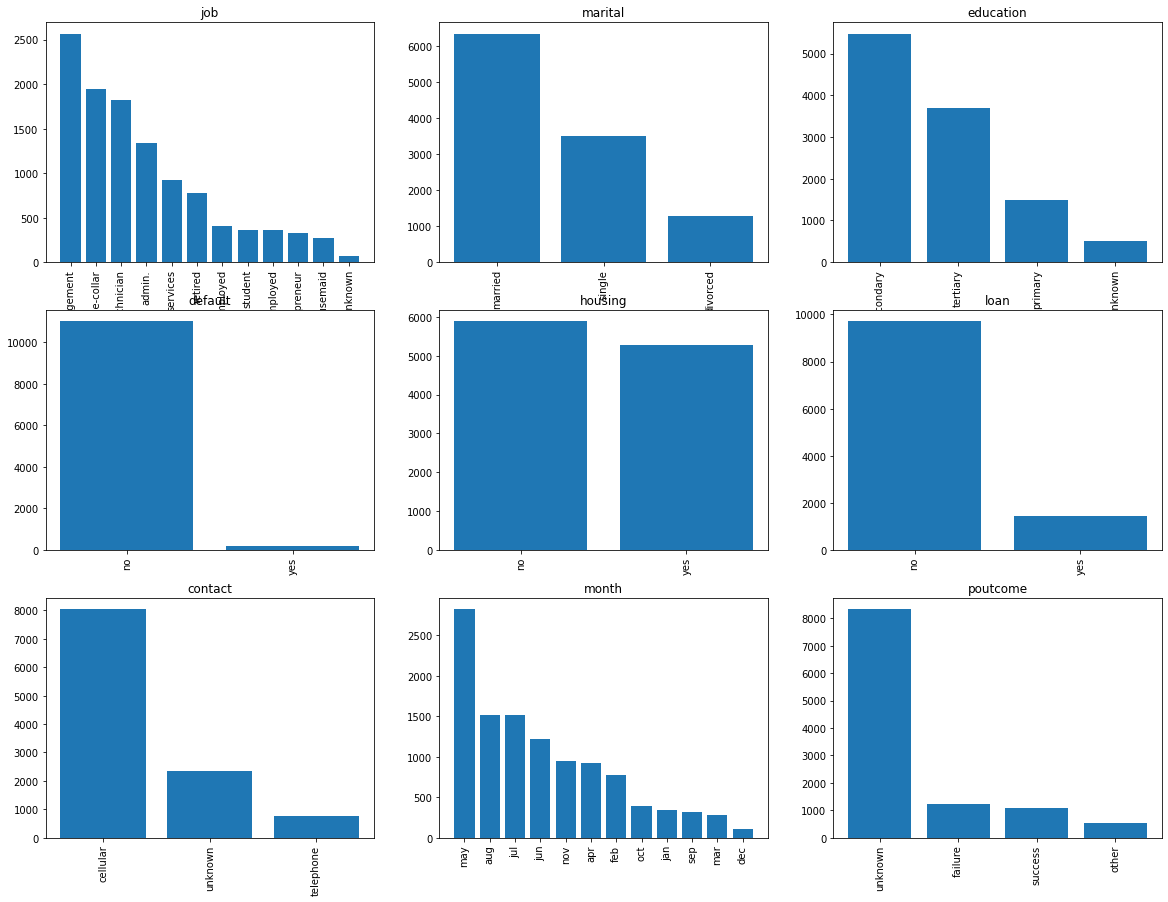

In [121]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

### Numerical columns exploration

Now let's look at the numerical columns' values. The most convenient way to look at the numerical values is plotting histograms.

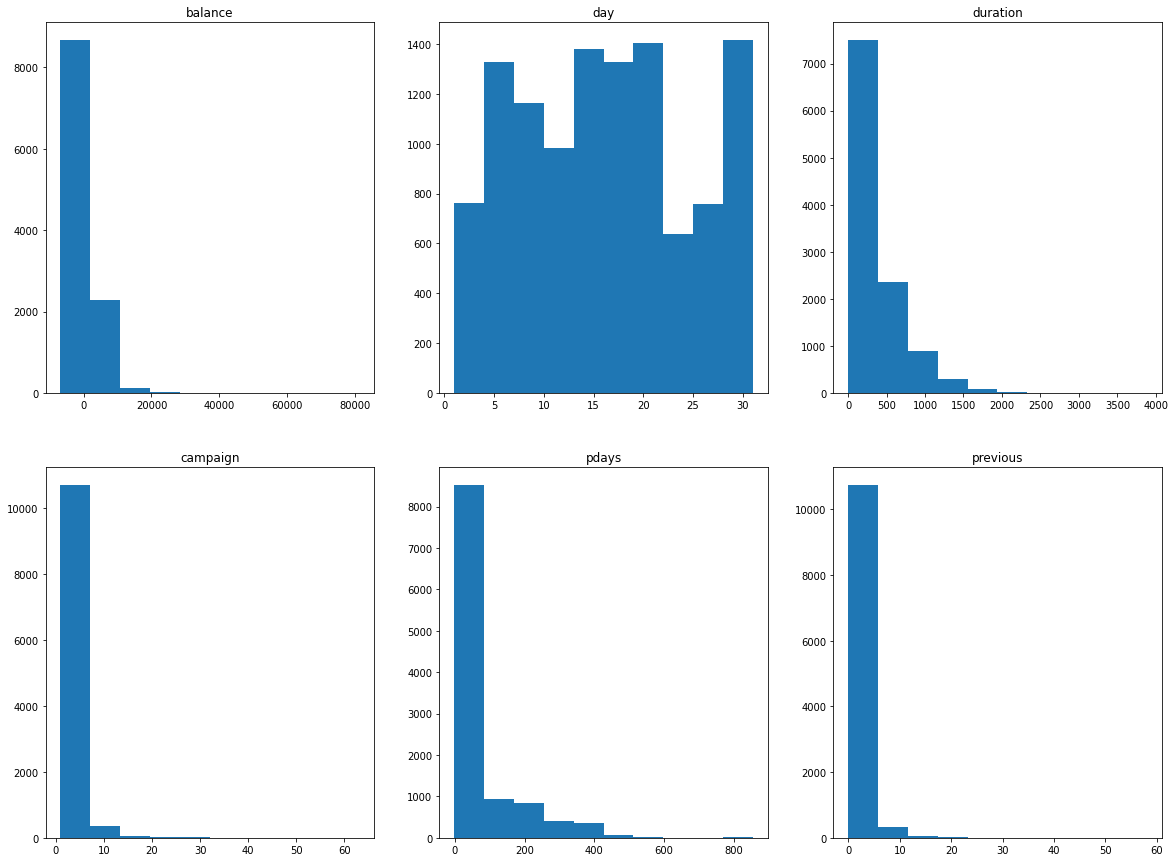

In [122]:
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    axs[trace_x, trace_y].hist(df[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

We can see that numerical columns have outliers (especially 'pdays', 'campaign' and 'previous' columns). Possibly there are incorrect values (noisy data), so we should look closer at the data and decide how do we manage the noise.
<br> Let's look closer at the values of 'campaign', 'pdays' and 'previous' columns:

In [123]:
df[['pdays', 'campaign', 'previous']].describe()

pdays      campaign      previous
count  11162.000000  11162.000000  11162.000000
mean      51.330407      2.508421      0.832557
std      108.758282      2.722077      2.292007
min       -1.000000      1.000000      0.000000
25%       -1.000000      1.000000      0.000000
50%       -1.000000      2.000000      0.000000
75%       20.750000      3.000000      1.000000
max      854.000000     63.000000     58.000000

Percentage of 'pdays' values above 400:

In [124]:
len (df[df['pdays'] > 400] ) / len(df) * 100

1.2005017022039062

'pdays' holds the number of days that passed by after the client was last contacted from a previous campaign
Looking closer into 'pdays' data we can see that:
* only 1.2% of values above 400. They are possibly outliers, so we should consider imputing something (possibly mean value) instead of these values.
* -1 possibly means that the client wasn't contacted before or stands for missing data.

Since we are not sure exactly what -1 means I suggest to drop this column, because -1 makes more than 50% of the values of the column.

Percentage of 'campaign' values above 20:

In [125]:
len (df[df['campaign'] > 34] ) / len(df) * 100

0.035835871707579285

'campaign' holds the number of contacts performed during this campaign and for this client (numeric, includes last contact)
Numbers for 'campaign' above 34 are clearly noise, so I suggest to impute them with average campaign values while data cleaning.

Percentage of 'previous' values above 20:

In [126]:
len (df[df['previous'] > 34] ) / len(df) * 100

0.04479483963447411

'previous' holds the number of contacts performed before this campaign and for this client (numeric)
Numbers for 'previous' above 34 are also really strange, so I suggest to impute them with average campaign values while data cleaning.

### Analysis of the response column

It is very important to look at the response column, which holds the information, which we are going to predict. In our case we should look at 'deposit' column and compare its values to other columns. 
<br> First of all we should look at the number of 'yes' and 'no' values in the response column 'deposit'.

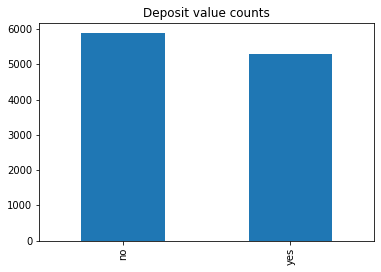

In [127]:
value_counts = df['deposit'].value_counts()

value_counts.plot.bar(title = 'Deposit value counts')

On the diagram we see that counts for 'yes' and 'no' values for 'deposit' are close, so we can use accuracy as a metric for a model, which predicts the campaign outcome.

Let's see how 'deposit' column value varies depending on other categorical columns' values:

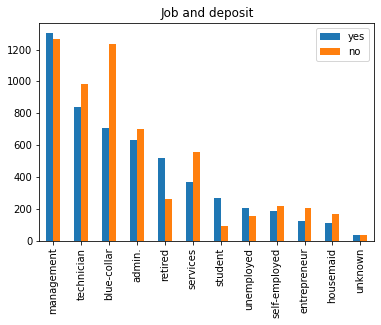

In [128]:
#job and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Job and deposit')

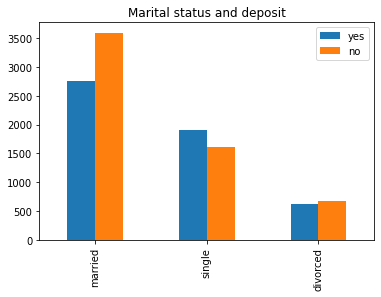

In [129]:
#marital status and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')

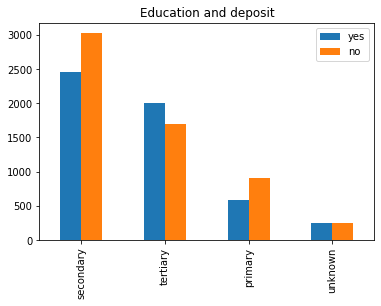

In [130]:
#education and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Education and deposit')

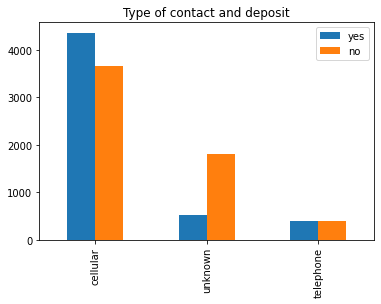

In [131]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Type of contact and deposit')

Regarding the diagrams we can tell that according to our dataset:
1. Customers with 'blue-collar' and 'services' jobs are less likely to subscribe for term deposit.
2. Married customers are less likely to subscribe for term deposit.
3. Customers with 'cellular' type of contact are less likely to subscribe for term deposit.

Now let's look how numerical columns affect term deposit subscription.

In [132]:
#balance and deposit

b_df = pd.DataFrame()
b_df['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
b_df['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']

b_df

balance_yes    balance_no
count   5289.000000   5873.000000
mean    1804.267915   1280.227141
std     3501.104777   2933.411934
min    -3058.000000  -6847.000000
25%      210.000000     64.000000
50%      733.000000    414.000000
75%     2159.000000   1324.000000
max    81204.000000  66653.000000

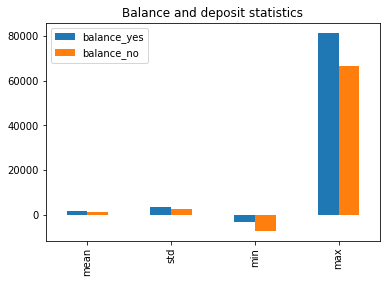

In [133]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance and deposit statistics')

In [134]:
#age and deposit

a_df = pd.DataFrame()
a_df['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
a_df['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']

a_df

age_yes       age_no
count  5289.000000  5873.000000
mean     41.670070    40.837391
std      13.497781    10.264815
min      18.000000    18.000000
25%      31.000000    33.000000
50%      38.000000    39.000000
75%      50.000000    48.000000
max      95.000000    89.000000

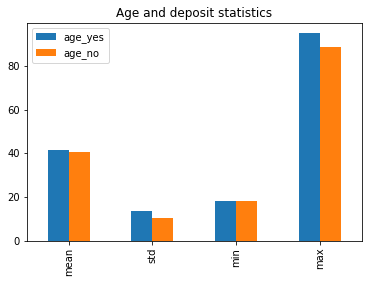

In [135]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age and deposit statistics')

In [136]:
#number of contacts performed during this campaign ('campaign') and deposit
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

c_df

campaign_yes  campaign_no
count   5289.000000  5873.000000
mean       2.141047     2.839264
std        1.921826     3.244474
min        1.000000     1.000000
25%        1.000000     1.000000
50%        2.000000     2.000000
75%        3.000000     3.000000
max       32.000000    63.000000

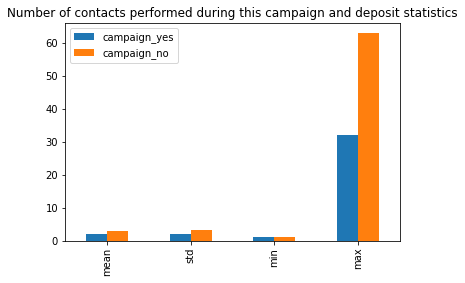

In [137]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during this campaign and deposit statistics')

In [138]:
#number of contacts performed during previous campaign ('previous') and deposit
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
p_df['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']

p_df

previous_yes  previous_no
count   5289.000000   5873.00000
mean       1.170354      0.52835
std        2.553272      1.97961
min        0.000000      0.00000
25%        0.000000      0.00000
50%        0.000000      0.00000
75%        1.000000      0.00000
max       58.000000     41.00000

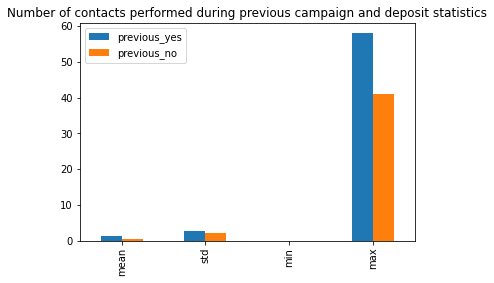

In [139]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during previous campaign and deposit statistics')

Looking at the diagrams above we can conclude that:
1. People who subscribed for term deposit tend to have greater balance and age values.
2. People who subscribed for term deposit tend to have fewer number of contacts during this campaign.

## Data Cleaning

Before we will be able to apply machine learning techniques, we should prepare the dataset for processing:
1. Convert columns with 'yes' and 'no' values to boolean columns;
2. Convert categorical columns into dummy variables.

In [140]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset
    
    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    '''
    
    cleaned_df = df.copy()
    
    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = bool_columns)
    
    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])
    
    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])
    
    return cleaned_df

In [141]:
#clean the dataset
cleaned_df = clean_data(df)
cleaned_df.head()

age  balance  day  duration  default_bool  housing_bool  loan_bool  \
0   59     2343    5      1042             0             1          0   
1   56       45    5      1467             0             0          0   
2   41     1270    5      1389             0             1          0   
3   55     2476    5       579             0             1          0   
4   54      184    5       673             0             0          0   

   deposit_bool  job_blue-collar  job_entrepreneur  ...  month_mar  month_may  \
0             1                0                 0  ...          0          1   
1             1                0                 0  ...          0          1   
2             1                0                 0  ...          0          1   
3             1                0                 0  ...          0          1   
4             1                0                 0  ...          0          1   

   month_nov  month_oct  month_sep  poutcome_other  poutcome_success  \
0          0          0          0               0                 0   
1          0          0          0               0                 0   
2          0          0          0               0                 0   
3          0          0          0               0                 0   
4          0          0          0               0                 0   

   poutcome_unknown  campaign_cleaned  previous_cleaned  
0                 1               1.0               0.0  
1                 1               1.0               0.0  
2                 1               1.0               0.0  
3                 1               1.0               0.0  
4                 1               2.0               0.0  

[5 rows x 42 columns]

## Machine Learning for prediction of campaign outcome

### Classification model for the campaign outcome prediction

Now let's use cleaned datasets for prediction of campaign outcome with help of machine learning classification models. I will use __[XGBoost](https://xgboost.readthedocs.io/en/latest/)__, which is one of the most common machine learning libraries for modelling.
<br> Resulting model will also help me to understand, which features have the greatest importance for the prediction of the results of the campaing.

Create X and y datasets for training the model and split into train and test datasets.

In [142]:
X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]

In [143]:
TEST_SIZE = 0.3
RAND_STATE = 42

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)


In [145]:
# Time for Classification Models
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


dict_classifiers = {
    
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=18),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB()
}

In [146]:

no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [147]:
df_results = batch_classify(X_train, y_train.values.ravel())
print(df_results.sort_values(by='train_score', ascending=False))

trained Nearest Neighbors in 0.07 s
trained Linear SVM in 29.48 s
trained Gradient Boosting Classifier in 4.30 s
trained Decision Tree in 0.26 s
trained Random Forest in 0.82 s
trained Neural Net in 4.00 s
trained Naive Bayes in 0.03 s
                     classifier  train_score  training_time
3                 Decision Tree     1.000000       0.260345
1                    Linear SVM     0.998592      29.478653
4                 Random Forest     0.997184       0.815663
2  Gradient Boosting Classifier     0.858825       4.296395
0             Nearest Neighbors     0.797389       0.069020
6                   Naive Bayes     0.731345       0.033541
5                    Neural Net     0.660694       4.002152


## <center>Ans #2. <u>Accuracy, Precision and Recall in Test Data </u></center>

In [154]:

no_classifiers = len(dict_classifiers.keys())

def all_scores(X_train, Y_train,xtest,ytest, verbose = False):
    df_scores = pd.DataFrame(data=np.zeros(shape=(no_classifiers,5)), columns = ['classifier', 'train_score', 'test_accuracy','precision_score','recall_score'])
    count = 0
    for key, classifier in dict_classifiers.items():
        
        classifier.fit(X_train, Y_train)
        y_predict =classifier.predict(xtest)
        train_score = classifier.score(X_train, Y_train)
        test_accuracy = accuracy_score(y_predict, ytest)
        precision = precision_score(y_predict, ytest)
        recall = recall_score(y_predict, ytest)
        
        df_scores.loc[count,'classifier'] = key
        df_scores.loc[count,'train_score'] = train_score
        df_scores.loc[count,'test_accuracy'] = test_accuracy
        df_scores.loc[count,'precision_score'] = precision
        df_scores.loc[count,'recall_score'] = recall
        
        count+=1
    return df_scores

In [155]:
df_scores = all_scores(X_train, y_train.values.ravel(), X_test,y_test.values.ravel())
display(df_scores.sort_values(by='train_score', ascending=False))

classifier  train_score  test_accuracy  precision_score  \
3                 Decision Tree     1.000000       0.780532         0.765401   
1                    Linear SVM     0.998592       0.522245         0.049782   
4                 Random Forest     0.998080       0.831592         0.834474   
2  Gradient Boosting Classifier     0.858825       0.840848         0.856254   
0             Nearest Neighbors     0.797389       0.710958         0.676416   
5                    Neural Net     0.783438       0.779636         0.878656   
6                   Naive Bayes     0.731345       0.742311         0.588052   

   recall_score  
3      0.774559  
1      0.522876  
4      0.818182  
2      0.820024  
0      0.708143  
5      0.722251  
6      0.824607

## <center><u> Ans#4 (i) Comments on Bias and Variance</u></center>

<b>Descion Tree</b>       : Low bias and High Variance. Model is Over Fit <n>
<br>
    
<b>Linear SVM</b>         : Low Bias and very High Variance. Model is Over Fit
<br>

<b>Random Forest</b>      : Low Bias and High Variance. Model is Over Fit
<br>

<b>Gradient Boosting</b>  : Low Bias and Low Variance. Model generalized well
<br>

<b>Nearest Neighbours</b> : High Bias and High Variance. Model is Under Fit
<br>

<b>Neural Net</b>         : High Bias and High Variance. Model is Under Fit
<br>

<b>Naive Bayes</b>        : High Bias and High Variance. Model is Under Fit


In [35]:
results = df_scores.sort_values(by='train_score', ascending=False)

### Avoiding Overfitting:
Brief Description of Overfitting?<br>
This is an error in the modeling algorithm that takes into consideration random noise in the fitting process rather than the pattern itself. You can see that this occurs when the model gets an awsome score in the training set but when we use the test set (Unknown data for the model) we get an awful score. This is likely to happen because of overfitting of the data (taking into consideration random noise in our pattern). What we want our model to do is to take the overall pattern of the data in order to correctly classify whether a potential client will suscribe to a term deposit or not. In the examples above, it is most likely that the Decision Tree Classifier and Random Forest classifiers are overfitting since they both give us nearly perfect scores (100% and 99%) accuracy scores. <br><br>


How can we avoid Overfitting?<br>
The best alternative to avoid overfitting is to use cross validation. Taking the training test and splitting it. For instance, if we split it by 3, 2/3 of the data or 66% will be used for training and 1/3 33% will be used or testing and we will do the testing process three times. This algorithm will iterate through all the training and test sets and the main purpose of this is to grab the overall pattern of the data.

In [36]:
# Use Cross-validation.
from sklearn.model_selection import cross_val_score
y_train=y_train.values.ravel()
# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3)
nav_mean = nav_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': [ 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

In [37]:
# All our models perform well but I will go with GradientBoosting.
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

Classifiers  Crossval Mean Scores
3         Grad B CLF              0.844363
4            Rand FC              0.837451
2           Dec Tree              0.776654
5  Neural Classifier              0.765400
6       Naives Bayes              0.728914
1                KNN              0.708946
0                SVC              0.529631

# <center>Ans #3. <u>Function for Cross Validation</u></center>

In [38]:
from sklearn.model_selection import cross_val_predict
no_classifiers = len(dict_classifiers.keys())

def cross_validation(X_train, y_train, verbose = False):
    #y_train=y_train.values.ravel()
    cv_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,2)), columns = ['classifier', 'Cross Val Mean Score'])
    count = 0
    for key, classifier in dict_classifiers.items():
        classifier_scores = cross_val_score(classifier, X_train, y_train, cv=3)
        classifier_mean = classifier_scores.mean()
        
        cv_results.loc[count,'classifier'] = key
        cv_results.loc[count,'Cross Val Mean Score'] = classifier_mean
        
        count+=1
    return cv_results

In [39]:
#Function Call
cv_results = cross_validation(X_train, y_train)

In [40]:
cv_results.sort_values(by='Cross Val Mean Score', ascending=False)

classifier  Cross Val Mean Score
2  Gradient Boosting Classifier              0.844363
4                 Random Forest              0.836427
3                 Decision Tree              0.775502
5                    Neural Net              0.736329
6                   Naive Bayes              0.728914
0             Nearest Neighbors              0.708946
1                    Linear SVM              0.529631

# <center>Ans #4 (ii). <u>Hyperparameter Tuning</u></center>

In [41]:
from sklearn.model_selection import GridSearchCV
data=[]

## 1. Nearest Neighbors Classifier

In [42]:
knn = KNeighborsClassifier()
hyperparameters = {'n_neighbors' : list(range(1,30)), 'p':[1,2]}
knn_classifier =  GridSearchCV(knn, hyperparameters, refit=True, cv=3)
knn_classifier.fit(X_train,y_train);

In [43]:
print("The best fit value is found out to be :" ,knn_classifier.best_params_)

The best fit value is found out to be : {'n_neighbors': 25, 'p': 1}


### 1.1. Change of Cross Validation Score on Training Set

In [44]:
#knn = KNeighborsClassifier(n_neighbors=25, p=1)
knn_classifier_scores = cross_val_score(knn_classifier, X_train, y_train, cv=3)
knn_classifier_scores.mean()

cv_results['CV Score (HyperParamter Tuned)']= np.nan
cv_results.loc[cv_results['classifier']=='Nearest Neighbors','CV Score (HyperParamter Tuned)'] =knn_classifier_scores.mean()
data=cv_results
cv_results

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  
0                        0.734161  
1                             NaN  
2                             NaN  
3                             NaN  
4                             NaN  
5                             NaN  
6                             NaN

### 1.2. Error on Training Set before and after HyperParameter Tunning

In [45]:
training_error_change = df_results.loc[:,['classifier','train_score']]
training_error_change['train_score(after tunning)'] = np.nan

In [46]:
knn_training_score = knn_classifier.score(X_train,y_train)
training_error_change.loc[training_error_change['classifier']=='Nearest Neighbors','train_score(after tunning)'] = knn_training_score
data=data.merge(training_error_change,'right')
training_error_change

classifier  train_score  train_score(after tunning)
0             Nearest Neighbors     0.797389                    0.756816
1                    Linear SVM     0.998592                         NaN
2  Gradient Boosting Classifier     0.858825                         NaN
3                 Decision Tree     1.000000                         NaN
4                 Random Forest     0.997952                         NaN
5                    Neural Net     0.719826                         NaN
6                   Naive Bayes     0.731345                         NaN

### 1.3. Comparision of Test Accuracy before and after Hyperparamter Tuning

In [47]:
testing_error_change = df_results.loc[:,['classifier','test_accuracy']]
testing_error_change['testing_score(after tunning)'] = np.nan

y_pred = knn_classifier.predict(X_test)

knn_testing_score = accuracy_score(y_pred,y_test)

testing_error_change.loc[testing_error_change['classifier']=='Nearest Neighbors','testing_score(after tunning)'] = knn_testing_score

data = data.merge(testing_error_change,'right')

testing_error_change

classifier  test_accuracy  testing_score(after tunning)
0             Nearest Neighbors       0.710958                      0.734548
1                    Linear SVM       0.522245                           NaN
2  Gradient Boosting Classifier       0.840848                           NaN
3                 Decision Tree       0.779636                           NaN
4                 Random Forest       0.831890                           NaN
5                    Neural Net       0.727979                           NaN
6                   Naive Bayes       0.742311                           NaN

In [48]:
data

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  train_score  train_score(after tunning)  \
0                        0.734161     0.797389                    0.756816   
1                             NaN     0.998592                         NaN   
2                             NaN     0.858825                         NaN   
3                             NaN     1.000000                         NaN   
4                             NaN     0.997952                         NaN   
5                             NaN     0.719826                         NaN   
6                             NaN     0.731345                         NaN   

   test_accuracy  testing_score(after tunning)  
0       0.710958                      0.734548  
1       0.522245                           NaN  
2       0.840848                           NaN  
3       0.779636                           NaN  
4       0.831890                           NaN  
5       0.727979                           NaN  
6       0.742311                           NaN

## 2. Random Forest

In [49]:
RF= RandomForestClassifier()
hyperparameters = {'n_estimators' :[1,2,5,10,15,25,30], 'max_features':[2,4,6,8],'max_depth':[10, 20, 25,30, 40, 50]}
RF_classifier =  GridSearchCV(RF, hyperparameters, refit=True, cv=3)
RF_classifier.fit(X_train,y_train);

In [50]:
print("The best fit value is found out to be :" ,RF_classifier.best_params_)

The best fit value is found out to be : {'max_depth': 20, 'max_features': 8, 'n_estimators': 30}


### 2.1. Change of Cross Validation Score on Training Set

In [51]:
RF_classifier_scores = cross_val_score(RF_classifier, X_train, y_train, cv=3)
RF_classifier_scores.mean()

#cv_results['CV Score (HyperParamter Tuned)']= np.nan
cv_results.loc[cv_results['classifier']=='Random Forest','CV Score (HyperParamter Tuned)'] =RF_classifier_scores.mean()
data.loc[data['classifier']=='Random Forest','CV Score (HyperParamter Tuned)'] =RF_classifier_scores.mean()
cv_results

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  
0                        0.734161  
1                             NaN  
2                             NaN  
3                             NaN  
4                        0.838859  
5                             NaN  
6                             NaN

### 2.2. Error on Training Set before and after HyperParameter Tunning

In [52]:
#training_error_change = df_results.loc[:,['classifier','train_score']]
#training_error_change['train_score(after tunning)'] = np.nan

RF_training_score = RF_classifier.score(X_train,y_train)
training_error_change.loc[training_error_change['classifier']=='Random Forest','train_score(after tunning)'] = RF_training_score
data.loc[data['classifier']=='Random Forest','train_score(after tunning)'] = RF_training_score
training_error_change

classifier  train_score  train_score(after tunning)
0             Nearest Neighbors     0.797389                    0.756816
1                    Linear SVM     0.998592                         NaN
2  Gradient Boosting Classifier     0.858825                         NaN
3                 Decision Tree     1.000000                         NaN
4                 Random Forest     0.997952                    0.994112
5                    Neural Net     0.719826                         NaN
6                   Naive Bayes     0.731345                         NaN

### 2.3. Comparision of Test Accuracy before and after Hyperparamter Tuning

In [53]:
#testing_error_change = df_results.loc[:,['classifier','test_accuracy']]
#testing_error_change['testing_score(after tunning)'] = np.nan

y_pred = RF_classifier.predict(X_test)

RF_testing_score = accuracy_score(y_pred,y_test)

testing_error_change.loc[testing_error_change['classifier']=='Random Forest','testing_score(after tunning)'] = RF_testing_score

data.loc[data['classifier']=='Random Forest','testing_score(after tunning)'] = RF_testing_score

testing_error_change

classifier  test_accuracy  testing_score(after tunning)
0             Nearest Neighbors       0.710958                      0.734548
1                    Linear SVM       0.522245                           NaN
2  Gradient Boosting Classifier       0.840848                           NaN
3                 Decision Tree       0.779636                           NaN
4                 Random Forest       0.831890                      0.843834
5                    Neural Net       0.727979                           NaN
6                   Naive Bayes       0.742311                           NaN

In [54]:
data

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  train_score  train_score(after tunning)  \
0                        0.734161     0.797389                    0.756816   
1                             NaN     0.998592                         NaN   
2                             NaN     0.858825                         NaN   
3                             NaN     1.000000                         NaN   
4                        0.838859     0.997952                    0.994112   
5                             NaN     0.719826                         NaN   
6                             NaN     0.731345                         NaN   

   test_accuracy  testing_score(after tunning)  
0       0.710958                      0.734548  
1       0.522245                           NaN  
2       0.840848                           NaN  
3       0.779636                           NaN  
4       0.831890                      0.843834  
5       0.727979                           NaN  
6       0.742311                           NaN

## 3.Decision Tree

In [55]:
DT = tree.DecisionTreeClassifier()
hyperparameters = {'criterion' :['gini','entropy'], 'max_features':[2,4,6,8],'max_depth':[10, 20, 25, 30, 40, 50]},
DT_classifier =  GridSearchCV(DT, hyperparameters, refit=True, cv=3)
DT_classifier.fit(X_train,y_train);

In [56]:
print("The best fit value is found out to be :" ,DT_classifier.best_params_)

The best fit value is found out to be : {'criterion': 'gini', 'max_depth': 10, 'max_features': 8}


### 3.1. Change of Cross Validation Score on Training Set

In [57]:
DT_classifier_scores = cross_val_score(DT_classifier, X_train, y_train, cv=3)
DT_classifier_scores.mean()

#cv_results['CV Score (HyperParamter Tuned)']= np.nan
cv_results.loc[cv_results['classifier']=='Decision Tree','CV Score (HyperParamter Tuned)'] =DT_classifier_scores.mean()
data.loc[data['classifier']=='Decision Tree','CV Score (HyperParamter Tuned)'] =DT_classifier_scores.mean()
cv_results

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  
0                        0.734161  
1                             NaN  
2                             NaN  
3                        0.773453  
4                        0.838859  
5                             NaN  
6                             NaN

### 3.2. Error on Training Set before and after HyperParameter Tunning

In [58]:
#training_error_change = df_results.loc[:,['classifier','train_score']]
#training_error_change['train_score(after tunning)'] = np.nan

DT_training_score = DT_classifier.score(X_train,y_train)
training_error_change.loc[training_error_change['classifier']=='Decision Tree','train_score(after tunning)'] = DT_training_score
data.loc[data['classifier']=='Decision Tree','train_score(after tunning)'] = DT_training_score
training_error_change

classifier  train_score  train_score(after tunning)
0             Nearest Neighbors     0.797389                    0.756816
1                    Linear SVM     0.998592                         NaN
2  Gradient Boosting Classifier     0.858825                         NaN
3                 Decision Tree     1.000000                    0.861001
4                 Random Forest     0.997952                    0.994112
5                    Neural Net     0.719826                         NaN
6                   Naive Bayes     0.731345                         NaN

### 3.3. Comparision of Test Accuracy before and after Hyperparamter Tuning

In [59]:
#testing_error_change = df_results.loc[:,['classifier','test_accuracy']]
#testing_error_change['testing_score(after tunning)'] = np.nan

y_pred = DT_classifier.predict(X_test)

DT_testing_score = accuracy_score(y_pred,y_test)

testing_error_change.loc[testing_error_change['classifier']=='Decision Tree','testing_score(after tunning)'] = DT_testing_score

data.loc[data['classifier']=='Decision Tree','testing_score(after tunning)'] = DT_testing_score

testing_error_change

classifier  test_accuracy  testing_score(after tunning)
0             Nearest Neighbors       0.710958                      0.734548
1                    Linear SVM       0.522245                           NaN
2  Gradient Boosting Classifier       0.840848                           NaN
3                 Decision Tree       0.779636                      0.789788
4                 Random Forest       0.831890                      0.843834
5                    Neural Net       0.727979                           NaN
6                   Naive Bayes       0.742311                           NaN

In [60]:
data

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  train_score  train_score(after tunning)  \
0                        0.734161     0.797389                    0.756816   
1                             NaN     0.998592                         NaN   
2                             NaN     0.858825                         NaN   
3                        0.773453     1.000000                    0.861001   
4                        0.838859     0.997952                    0.994112   
5                             NaN     0.719826                         NaN   
6                             NaN     0.731345                         NaN   

   test_accuracy  testing_score(after tunning)  
0       0.710958                      0.734548  
1       0.522245                           NaN  
2       0.840848                           NaN  
3       0.779636                      0.789788  
4       0.831890                      0.843834  
5       0.727979                           NaN  
6       0.742311                           NaN

## 4. Linear SVM

Tried to find best parameters multiple times using both grid and randomize search for but notebook reamins busy even after 2 hours. Therefore leaving it for now

In [61]:
from sklearn.model_selection import RandomizedSearchCV as RS

### 4.1. Change of Cross Validation Score on Train Data

### 4.2. Error on Training Set before and after HyperParameter Tunning

### 4.3. Comparision of Test Accuracy before and after Hyperparameter Tunning

## 5. Gradient Boosting

In [62]:
GBC = GradientBoostingClassifier()
hyperparameters = {'max_depth':[5,10,15,20,25,30,40,45,50], 'min_samples_split':[100,200,300,500]}

GBC_classifier =  GridSearchCV(GBC, hyperparameters, refit=True, cv=3)
GBC_classifier.fit(X_train,y_train);

In [63]:
print("The best fit value is found out to be :" ,GBC_classifier.best_params_)

The best fit value is found out to be : {'max_depth': 30, 'min_samples_split': 300}


### 5.1. Change of Cross Validation Score on Training Data

In [64]:
GBC_classifier = GradientBoostingClassifier(max_depth=30, min_samples_split=300)
GBC_classifier_scores = cross_val_score(GBC_classifier, X_train, y_train, cv=3)
GBC_classifier_scores.mean()


cv_results.loc[cv_results['classifier']=='Gradient Boosting Classifier','CV Score (HyperParamter Tuned)'] =GBC_classifier_scores.mean()
data.loc[data['classifier']=='Gradient Boosting Classifier','CV Score (HyperParamter Tuned)'] =GBC_classifier_scores.mean()
cv_results

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  
0                        0.734161  
1                             NaN  
2                        0.857801  
3                        0.773453  
4                        0.838859  
5                             NaN  
6                             NaN

### 5.2. Error on Training Set before and after HyperParameter Tunning

In [66]:
GBC_classifier.fit(X_train,y_train);
GBC_training_score = GBC_classifier.score(X_train,y_train)
training_error_change.loc[training_error_change['classifier']=='Gradient Boosting Classifier','train_score(after tunning)'] = GBC_training_score
data.loc[data['classifier']=='Gradient Boosting Classifier','train_score(after tunning)'] = GBC_training_score
training_error_change

classifier  train_score  train_score(after tunning)
0             Nearest Neighbors     0.797389                    0.756816
1                    Linear SVM     0.998592                         NaN
2  Gradient Boosting Classifier     0.858825                    0.973250
3                 Decision Tree     1.000000                    0.861001
4                 Random Forest     0.997952                    0.994112
5                    Neural Net     0.719826                         NaN
6                   Naive Bayes     0.731345                         NaN

### 5.3. Comparision of Test Accuracy before and after Hyperparameter Tunning

In [67]:
y_pred = GBC_classifier.predict(X_test)

GBC_testing_score = accuracy_score(y_pred,y_test)

testing_error_change.loc[testing_error_change['classifier']=='Gradient Boosting Classifier','testing_score(after tunning)'] = GBC_testing_score

data.loc[data['classifier']=='Gradient Boosting Classifier','testing_score(after tunning)'] = GBC_testing_score

testing_error_change

classifier  test_accuracy  testing_score(after tunning)
0             Nearest Neighbors       0.710958                      0.734548
1                    Linear SVM       0.522245                           NaN
2  Gradient Boosting Classifier       0.840848                      0.849209
3                 Decision Tree       0.779636                      0.789788
4                 Random Forest       0.831890                      0.843834
5                    Neural Net       0.727979                           NaN
6                   Naive Bayes       0.742311                           NaN

In [68]:
data

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  train_score  train_score(after tunning)  \
0                        0.734161     0.797389                    0.756816   
1                             NaN     0.998592                         NaN   
2                        0.857801     0.858825                    0.973250   
3                        0.773453     1.000000                    0.861001   
4                        0.838859     0.997952                    0.994112   
5                             NaN     0.719826                         NaN   
6                             NaN     0.731345                         NaN   

   test_accuracy  testing_score(after tunning)  
0       0.710958                      0.734548  
1       0.522245                           NaN  
2       0.840848                      0.849209  
3       0.779636                      0.789788  
4       0.831890                      0.843834  
5       0.727979                           NaN  
6       0.742311                           NaN

# 6. Naive Bayes

In [69]:
NB = GaussianNB()
hyperparameters = {'var_smoothing':np.logspace(0,-9, num=100)}

NB_classifier =  GridSearchCV(NB, hyperparameters, refit=True, cv=3)
NB_classifier.fit(X_train,y_train);

### 6.2. Change of Cross Validation Score on Train Data

In [70]:
NB_classifier_scores = cross_val_score(NB_classifier, X_train, y_train, cv=3)
NB_classifier_scores.mean()

#cv_results['CV Score (HyperParamter Tuned)']= np.nan
cv_results.loc[cv_results['classifier']=='Naive Bayes','CV Score (HyperParamter Tuned)'] =NB_classifier_scores.mean()
data.loc[data['classifier']=='Naive Bayes','CV Score (HyperParamter Tuned)'] =NB_classifier_scores.mean()
cv_results

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  
0                        0.734161  
1                             NaN  
2                        0.857801  
3                        0.773453  
4                        0.838859  
5                             NaN  
6                        0.767695

### 6.3. Error on Training Set before and after Hyperparamter Tunning

In [71]:

NB_training_score = NB_classifier.score(X_train,y_train)
training_error_change.loc[training_error_change['classifier']=='Naive Bayes','train_score(after tunning)'] = NB_training_score
data.loc[data['classifier']=='Naive Bayes','train_score(after tunning)'] = NB_training_score
training_error_change

classifier  train_score  train_score(after tunning)
0             Nearest Neighbors     0.797389                    0.756816
1                    Linear SVM     0.998592                         NaN
2  Gradient Boosting Classifier     0.858825                    0.973250
3                 Decision Tree     1.000000                    0.861001
4                 Random Forest     0.997952                    0.994112
5                    Neural Net     0.719826                         NaN
6                   Naive Bayes     0.731345                    0.766799

### 6.3. Comparision of Test Accuracy before and after Hyperparameter Tunning

In [72]:
y_pred = NB_classifier.predict(X_test)

NB_testing_score = accuracy_score(y_pred,y_test)

testing_error_change.loc[testing_error_change['classifier']=='Naive Bayes','testing_score(after tunning)'] = NB_testing_score

data.loc[data['classifier']=='Naive Bayes','testing_score(after tunning)'] = NB_testing_score

testing_error_change

classifier  test_accuracy  testing_score(after tunning)
0             Nearest Neighbors       0.710958                      0.734548
1                    Linear SVM       0.522245                           NaN
2  Gradient Boosting Classifier       0.840848                      0.849209
3                 Decision Tree       0.779636                      0.789788
4                 Random Forest       0.831890                      0.843834
5                    Neural Net       0.727979                           NaN
6                   Naive Bayes       0.742311                      0.768289

In [98]:
data2 =data.copy()
data

classifier  Cross Val Mean Score  \
0             Nearest Neighbors              0.708946   
1                    Linear SVM              0.529631   
2  Gradient Boosting Classifier              0.844363   
3                 Decision Tree              0.775502   
4                 Random Forest              0.836427   
5                    Neural Net              0.736329   
6                   Naive Bayes              0.728914   

   CV Score (HyperParamter Tuned)  train_score  train_score(after tunning)  \
0                        0.734161     0.797389                    0.756816   
1                             NaN     0.998592                         NaN   
2                        0.857801     0.858825                    0.973250   
3                        0.773453     1.000000                    0.861001   
4                        0.838859     0.997952                    0.994112   
5                             NaN     0.719826                         NaN   
6                        0.767695     0.731345                    0.766799   

   test_accuracy  testing_score(after tunning)  
0       0.710958                      0.734548  
1       0.522245                           NaN  
2       0.840848                      0.849209  
3       0.779636                      0.789788  
4       0.831890                      0.843834  
5       0.727979                           NaN  
6       0.742311                      0.768289

In [109]:
data2 =data2.rename(columns = {'Cross Val Mean Score':'CV Score','CV Score (HyperParamter Tuned)':'CV Score<br>Parameter Tunned',
                               'train_score':'Train Score','train_score(after tunning)':'Train Score<br>Paramter Tuned',
                               'test_accuracy':'Test Score','testing_score(after tunning)':'Test Score<br>Parameter Tuned'})

In [113]:
data2.iloc[2,0]='Gradient Boosting'
data2

classifier  CV Score  CV Score<br>Parameter Tunned  Train Score  \
0  Nearest Neighbors  0.708946                      0.734161     0.797389   
1         Linear SVM  0.529631                           NaN     0.998592   
2  Gradient Boosting  0.844363                      0.857801     0.858825   
3      Decision Tree  0.775502                      0.773453     1.000000   
4      Random Forest  0.836427                      0.838859     0.997952   
5         Neural Net  0.736329                           NaN     0.719826   
6        Naive Bayes  0.728914                      0.767695     0.731345   

   Train Score<br>Paramter Tuned  Test Score  Test Score<br>Parameter Tuned  
0                       0.756816    0.710958                       0.734548  
1                            NaN    0.522245                            NaN  
2                       0.973250    0.840848                       0.849209  
3                       0.861001    0.779636                       0.789788  
4                       0.994112    0.831890                       0.843834  
5                            NaN    0.727979                            NaN  
6                       0.766799    0.742311                       0.768289

In [169]:
cols = list(data2.columns)
cols = ['classifier', 'CV Score', 'Train Score', 'Test Score', 'CV Score<br>Parameter Tunned', 'Train Score<br>Paramter Tuned',
         'Test Score<br>Parameter Tuned']
data3 =data2.copy()
#df = df[['favorite_color','grade','name','age']]

data3 = data3[['classifier', 'CV Score', 'Train Score', 'Test Score', 'CV Score<br>Parameter Tunned', 'Train Score<br>Paramter Tuned',
         'Test Score<br>Parameter Tuned']]
data3

classifier  CV Score  Train Score  Test Score  \
0  Nearest Neighbors  0.708946     0.797389    0.710958   
1         Linear SVM  0.529631     0.998592    0.522245   
2  Gradient Boosting  0.844363     0.858825    0.840848   
3      Decision Tree  0.775502     1.000000    0.779636   
4      Random Forest  0.836427     0.997952    0.831890   
5         Neural Net  0.736329     0.719826    0.727979   
6        Naive Bayes  0.728914     0.731345    0.742311   

   CV Score<br>Parameter Tunned  Train Score<br>Paramter Tuned  \
0                      0.734161                       0.756816   
1                           NaN                            NaN   
2                      0.857801                       0.973250   
3                      0.773453                       0.861001   
4                      0.838859                       0.994112   
5                           NaN                            NaN   
6                      0.767695                       0.766799   

   Test Score<br>Parameter Tuned  
0                       0.734548  
1                            NaN  
2                       0.849209  
3                       0.789788  
4                       0.843834  
5                            NaN  
6                       0.768289

In [ ]:
data3['Model before <br>Hyperparamters Tunning']= ['']

In [170]:
import plotly.offline as py
py.init_notebook_mode(connected = True)

import plotly.figure_factory as ff

table = ff.create_table(np.round(data3,3))
table.layout.width=1000

# Make text size larger
for i in range(len(table.layout.annotations)):
    table.layout.annotations[i].font.size = 12

py.iplot(table)


## <center>------*-----</center>

In [ ]:
# Cross validate our Gradient Boosting Classifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)

In [ ]:
y_train_pred

In [ ]:
from sklearn.metrics import accuracy_score
grad_clf.fit(X_train, y_train)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_train, y_train_pred))
y_test_pred=grad_clf.predict(X_test)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_test, y_test_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
# 4697: no's, 4232: yes
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show()

In [ ]:
# Let's find the scores  for precision and recall.
from sklearn.metrics import precision_score, recall_score
# The model is 77% sure that the potential client will suscribe to a term deposit. 
# The model is only retaining 60% of clients that agree to suscribe a term deposit.
print('Precision Score: ', precision_score(y_train, y_train_pred))
# The classifier only detects 60% of potential clients that will suscribe to a term deposit.
print('Recall Score: ', recall_score(y_train, y_train_pred))

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

In [ ]:
from sklearn.metrics import roc_curve
# Gradient Boosting Classifier

y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=3, method="decision_function")



grd_fpr, grd_tpr, thresold = roc_curve(y_train, y_scores)


In [ ]:
from sklearn.metrics import roc_auc_score

print('Gradient Boost Classifier Score: ', roc_auc_score(y_train, y_scores))

# Which Features Influence the Result of a Term Deposit Suscription?
## DecisionTreeClassifier:
<a id="decision"></a>
The top three most important features for our classifier are **Duration (how long it took the conversation between the sales representative and the potential client), contact (number of contacts to the potential client within the same marketing campaign),house.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
plt.style.use('seaborn-white')

# Convert the columns into categorical variables
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

# Let's create new splittings like before but now we modified the data so we need to do it one more time.
# Create train and test splits
target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
    
)



tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

Let's try to make more specific recommendations:

### Specific Recommendations

1. Find out account balance, which marketing campaign should focus on: 

In [ ]:
df_new = cleaned_df.copy()

#introduce new column 'balance_buckets' to  ''
df_new['balance_buckets'] = pd.qcut(df_new['balance'], 50, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['balance_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on account balance')
plt.xlabel('balance bucket')
plt.ylabel('% subscription')
plt.show()

In [ ]:
df_new[df_new['balance_buckets'] == 34]['balance'].min()

From the diagram above we can conclude, that marketing campaigns should concentrate on customers with account balance greater than 1490$.

In [ ]:
#introduce new column 'age_buckets' to  ''
df_new['age_buckets'] = pd.qcut(df_new['age'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_age = df_new.groupby(['age_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_age.index, mean_age.values)
plt.title('Mean % subscription depending on age')
plt.xlabel('age bucket')
plt.ylabel('% subscription')
plt.show()

In [ ]:
df_new[df_new['age_buckets'] == 3]['age'].max()

In [ ]:
df_new[df_new['age_buckets'] == 17]['age'].min()

So we see that average subscrition rate tends to be higher for customers below 31 years old or above 56 years old.

3. Find out appropriate number of contacts with the customer during campaign:

In [ ]:
#introduce new column 'age_buckets' to  ''
df_new['campaign_buckets'] = pd.qcut(df_new['campaign_cleaned'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_campaign = df_new.groupby(['campaign_buckets'])['deposit_bool'].mean()

#plot average campaign outcome per bucket 
plt.plot(mean_campaign.index, mean_campaign.values)
plt.title('Mean % subscription depending on number of contacts')
plt.xlabel('number of contacts bucket')
plt.ylabel('% subscription')
plt.show()

In [ ]:
df_new[df_new['campaign_buckets'] == 2]['campaign_cleaned'].min()

From the plot above we see that average subscription rate is below 50% if the number of contacts during the campaign exceeds 4.

## Conclusion

Key outcomes of the analysis are the recommendations for future marketing campaigns:
* The customer's account balance has a huge influence on the campaign's outcome. People with account balance above 1490$ are more likely to subscribe for term deposit, so future address those customers.
* The customer's age affects campaign outcome as well. Future campains should concentrate on customers from age categories below 30 years old and above 50 years old.
* Number of contacts with the customer during the campaign is also very important. The number of contacts with the customer shouldn't exceed 4.